In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation, record_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
import optunahub
from optuna.visualization import plot_slice, plot_param_importances
import shap
import random

gc.enable()

pd.options.display.max_columns = None
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

#pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)
#optuna.logging.set_verbosity(optuna.logging.WARNING)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
os.listdir(path)

['db.sqlite3',
 'features.csv',
 'imputed_train_ffill.parquet',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'team_folder',
 'test.parquet',
 'top_100000_rows_sorted_by_weight_descending.parquet',
 'top_10000_rows_sorted_by_weight_descending.parquet',
 'train.parquet']

In [4]:
train_df = pl.read_parquet(path + 'train.parquet/').select(pl.all().shrink_dtype())
lags_df = train_df.with_columns(pl.col('date_id') + 1).drop(['weight', 'partition_id'] + [col for col in train_df.columns if 'feature' in col]).rename({f'responder_{x}': f'responder_{x}_lag_1' for x in range(9)})
train_df = train_df.drop(['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_7', 'responder_8', 'partition_id']).select(pl.all().shrink_dtype())
train_df = train_df.join(lags_df, on=['date_id', 'time_id', 'symbol_id'], how='left').select(pl.all().shrink_dtype())
del lags_df
gc.collect()
train_df

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.775981,null,null,null,null,null,null,null,null,null
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,null,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,null,null,null,null,null,null,null,null,-10.835207,-0.002704,-0.621836,null,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,0.703665,null,null,null,null,null,null,null,null,null
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,null,-0.320921,-0.95809,-2.436589,0.070999,-0.245239,null,null,null,null,null,null,null,null,-1.420632,-3.515137,-4.67776,null,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,2.109352,null,null,null,null,null,null,null,null,null
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,null,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,null,null,null,null,null,null,null,null,0.382074,2.669135,0.611711,null,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-

In [5]:
train_df.estimated_size() / 1e9

17.032444032

In [6]:
models_path = path + 'my_folder/models/20250112_04/'
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [7]:
best_params = {
    'val_window_size': 1,
    'training_window_size': 764,
    'learning_rate': 0.04,
    'max_depth': 12,
    'min_data_in_leaf': 100,
    'num_leaves': 7000,
    'min_gain_to_split': 0.2792236337966436,
    'lambda_l1': 3.206704820777795,
    'lambda_l2': 4000.0,
    'feature_fraction': 0.9
}

In [8]:
tuned_params = {
    'learning_rate': 0.04,
    'max_depth': 12,
    'min_data_in_leaf': 100,
    'num_leaves': 7000,
    'min_gain_to_split': 0.2792236337966436,
    'lambda_l1': 3.206704820777795,
    'lambda_l2': 4000.0,
    'feature_fraction': 0.9
}

In [9]:
def lgb_sliding_window(train_data):

    #unique_date_ids = sorted(train_data['date_id'].unique())
    #unique_date_ids = [i for i in range(1110, train_data['date_id'].max() +1 -90)]
    #date_ids_df = train_data['date_id'].to_frame()
    date_id_max = train_data['date_id'].max()
    val_df = train_data.filter(pl.col('date_id') == date_id_max)

    train_dataset_start_date_id = date_id_max - 1 - best_params['training_window_size']
    train_dataset_df = train_data.filter((pl.col('date_id') < date_id_max)&(pl.col('date_id') > train_dataset_start_date_id))

    display(train_dataset_df)
    print(train_dataset_df['date_id'].n_unique())

    display(val_df)
    print(val_df['date_id'].n_unique())
    
    base_params = {
        'verbosity': -1,
        'device': 'gpu',
        'early_stopping_round': 20,
    }

    model = LGBMRegressor(
        **base_params,
        **tuned_params,
        n_estimators=100000
    )

    X_train = train_dataset_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
    X_val = val_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()

    y_train = train_dataset_df['responder_6'].to_pandas()
    y_val = val_df['responder_6'].to_pandas()

    weights_train = train_dataset_df['weight'].to_pandas()
    weights_val = val_df['weight'].to_pandas()

    model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=10)])

    best_iteration = model.best_iteration_
    print(f"Best iteration: {best_iteration}")

    plt.figure()
    lgb.plot_metric(model)
    plt.ylim(0, 1.5)
    plt.show()

    with open(models_path + "lgb_model.pkl", 'wb') as file:
        pickle.dump(model, file)

    return

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
934,0,0,2.12383,-0.534932,0.080834,-1.052302,-0.750956,2.70185,-0.690311,-0.196062,-0.517516,0.084836,11,7,76,-0.760092,2.831435,-0.105046,null,-0.19708,null,-1.531583,-1.334283,-0.191138,-0.206877,1.063284,1.316598,-0.81181,-0.945428,1.177981,1.459231,1.159154,0.060687,0.385985,-0.243129,null,null,-0.07636,-0.428531,-1.200056,-0.064891,0.493895,null,0.045529,null,null,-1.4528,null,-1.905297,0.812892,-0.668107,-0.462331,-0.252486,null,0.946356,null,null,-0.671964,null,-1.870155,1.933243,null,-0.192949,-0.061405,0.128164,-0.202995,-0.126351,-0.200067,-1.589248,-1.270459,-0.845317,2.684985,0.056045,-0.815895,1.555837,-0.319773,null,null,-0.220477,-0.329791,-0.342215,-0.421491,-0.181239,-0.198838,-0.380404,-0.494055,0.172298,0.554091,-0.375701,0.3884,1.0301,-0.157069
934,0,1,3.198076,-0.844356,0.31261,-0.997853,-1.1329,2.304455,-0.684999,-0.151595,-0.395924,0.045266,11,7,76,-0.633635,5.413635,0.387173,null,-0.210457,null,-1.093584,-1.722294,0.177795,0.092605,2.011978,1.422976,-0.227491,-0.432587,0.528809,1.574856,0.940915,-0.228851,-0.227591,0.06019,null,null,-0.138933,0.225358,-1.172756,0.090437,0.399906,null,-1.01645,null,null,-0.964548,null,-2.241071,0.857854,-0.887265,-0.190506,-0.430698,null,-0.412371,null,null,-1.444798,null,-2.381741,0.589127,null,-0.485751,-0.22577,0.128164,-0.31833,-0.292699,-0.372671,-1.765662,-1.246422,-0.43132,2.958668,0.37419,-0.531089,5.349477,0.462008,null,null,-0.256852,-0.239006,-0.255042,-0.488336,-0.116381,-0.545928,-0.081254,-0.792248,0.269795,0.563439,-0.030979,1.002458,1.15786,0.667285
934,0,2,2.052531,-0.691685,0.273557,-0.005726,-0.197722,2.313963,-0.753778,-0.170004,-0.604689,0.05279,81,2,59,-1.117372,0.725937,-0.492202,null,-0.287164,null,-2.256102,-2.370167,-0.402678,-0.269386,0.733584,-0.137729,-0.432946,-1.148054,0.315877,1.736617,1.736659,-0.59552,-0.688796,-0.157351,null,null,0.556375,1.120967,1.930995,0.204718,0.380802,null,-0.470876,null,null,-1.420836,null,-1.97589,1.00538,-0.168648,-0.279771,0.323967,null,-0.114947,null,null,-2.216987,null,-1.987117,0.379844,null,-6.284156,-2.018072,0.128164,-0.354447,-0.27588,-0.391588,-1.480433,-2.145177,-0.851924,0.539311,-0.317907,-1.164053,0.458108,-0.637548,null,null,0.196408,0.190466,-0.115554,-0.185597,1.893584,-0.387792,-0.141625,0.710901,1.881466,1.80328,0.882515,2.545819,1.98919,0.93675
934,0,3,1.591299,-0.703914,-0.150293,-0.866898,-0.764807,1.905868,-0.818862,-0.187308,-0.427535,0.088337,4,3,11,-0.936813,1.379267,-0.211719,null,-0.178754,null,-1.392007,-1.606018,-0.24242,0.147704,-0.246577,-0.957917,-0.487514,-0.700

764


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1698,0,0,3.743546,2.309442,1.404777,2.052407,1.860581,0.004939,0.188701,0.197857,0.082196,-0.130009,11,7,76,-0.877468,0.66075,-0.303573,null,-0.813168,null,-1.710606,-1.36424,1.515887,-0.202102,1.285443,0.787999,1.921844,1.28118,1.223592,1.002706,0.587736,-0.643336,-0.943377,-0.148149,null,null,2.471102,3.1923,1.058968,-0.026568,-0.07084,null,0.213756,null,null,-0.252723,null,-1.853614,1.491243,0.077845,0.239114,0.285436,null,0.30996,null,null,0.010683,null,-2.490269,1.25363,null,0.602921,0.247815,-1.101531,-0.518554,-0.324163,-0.393839,-1.251833,-1.461797,-0.867715,0.279538,-0.34136,-0.765203,0.423838,-0.355171,null,null,0.801169,0.69798,0.008923,0.010417,-1.305746,-0.18695,-0.321869,0.004191,1.303969,0.016202,0.492202,1.454441,0.188815,0.810413
1698,0,1,2.826357,2.046231,1.634353,1.32978,1.441716,-0.20124,0.270867,0.282076,0.11134,-0.147423,11,7,76,-0.797314,-0.177849,-0.583759,null,-0.518747,null,-1.047215,-1.435203,1.280485,-0.024357,0.936136,1.288942,0.845199,0.516642,-1.466948,0.035089,1.195631,-0.671953,-0.648468,-0.030753,null,null,3.110157,2.995877,0.57618,-0.01418,-0.09854,null,0.705042,null,null,0.097883,null,-1.483497,1.82934,1.154103,0.552413,0.33206,null,0.232119,null,null,0.478083,null,-1.589014,1.656754,null,0.519567,0.288318,-1.101531,-0.384534,-0.264305,-0.334309,-1.310108,-1.837694,-0.710028,-0.092546,-0.543664,-0.921565,-0.224318,-0.707887,null,null,0.105722,0.126959,-0.165226,-0.130599,-1.162801,0.186424,-0.002686,-0.068231,0.388099,-0.441538,-1.577833,0.5361,-0.575572,-1.121934
1698,0,2,3.120292,1.885471,1.183647,1.501341,1.861803,-0.034465,0.476829,0.354726,0.166955,-0.104411,81,2,59,-0.734696,0.202958,-0.686141,null,-0.448477,null,-1.156676,-1.350384,0.080837,-0.174716,1.078999,0.448147,0.117895,-0.68001,0.717676,0.83595,0.450227,-0.789566,-0.666649,-0.17165,null,null,3.087757,2.867494,-0.786288,-0.118076,-0.219686,null,1.008855,null,null,0.451247,null,-1.03067,1.25168,0.438099,0.704787,0.364057,null,2.091655,null,null,-0.608033,null,-1.280053,1.940492,null,4.676035,1.4092,-1.101531,-0.257202,-0.313653,-0.299827,-1.573021,-2.059235,-0.886751,0.241406,-0.489898,-0.973302,0.071241,-0.664589,null,null,0.441188,0.430596,-0.150894,-0.116166,-1.57429,-0.190361,0.083356,-0.506114,-0.043773,2.323234,1.465387,0.023251,2.438009,2.27166
1698,0,3,2.638314,1.946201,0.473077,1.512463,2.250226,-0.000911,0.255018,0.357259,0.107071,-0.199885,4,3,11,-0.945209,1.440261,-0.372922,null,-0.477212,null,-2.148908,-0.722694,-0.185432,-0.032784,0.513848,0.911167,0.1399,-0.494777,-0.010124,-0.061895,-0.303735,-0.

1
[10]	training's l2: 0.68042	valid_1's l2: 0.482523
[20]	training's l2: 0.676899	valid_1's l2: 0.481635
[30]	training's l2: 0.674258	valid_1's l2: 0.480907
[40]	training's l2: 0.671975	valid_1's l2: 0.480583
[50]	training's l2: 0.669723	valid_1's l2: 0.480395
[60]	training's l2: 0.66777	valid_1's l2: 0.480164
[70]	training's l2: 0.66569	valid_1's l2: 0.479987
[80]	training's l2: 0.663737	valid_1's l2: 0.479922
[90]	training's l2: 0.661948	valid_1's l2: 0.479712
[100]	training's l2: 0.660311	valid_1's l2: 0.479429
[110]	training's l2: 0.658705	valid_1's l2: 0.47939
[120]	training's l2: 0.656977	valid_1's l2: 0.479142
[130]	training's l2: 0.655567	valid_1's l2: 0.479018
[140]	training's l2: 0.653981	valid_1's l2: 0.47889
[150]	training's l2: 0.652527	valid_1's l2: 0.47876
[160]	training's l2: 0.651049	valid_1's l2: 0.478717
[170]	training's l2: 0.649751	valid_1's l2: 0.478528
[180]	training's l2: 0.648614	valid_1's l2: 0.478597
[190]	training's l2: 0.647189	valid_1's l2: 0.478541
Best i

<Figure size 640x480 with 0 Axes>

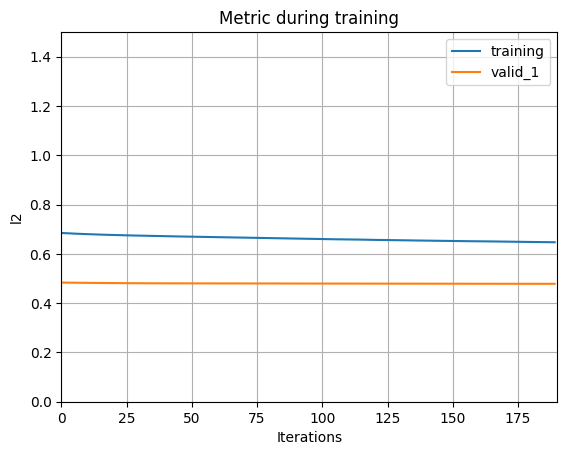

In [10]:
lgb_sliding_window(train_df)